# Outlier Detection and Removal

The raw nature of real-world data necessitates refining and organizing to render it suitable for analysis. Data cleaning stands as a crucial precursor to tackling practical data science tasks.  
  
Therefore, in this work, we will focus on outliers. We will distinguish between different types of outliers and explore methods for detecting and removing them. Specifically, we are using the **Interquartile Range Method, the Standard Deviation Method and the Density-Based Spatial Clustering of Applications with Noise.**  
Subsequently, we will apply various scaling techniques such as the **StandardScaler, MinMaxScaler and the RobustScaler.** Our model of choice is **linear regression.**  
For this purpose, the **insurance dataset** will serve as the basis for our analysis.

## What are outliers?

Outliers within datasets represent data points that deviate significantly from the rest of the observations. They arise from various factors such as errors in measurement or experimentation, as well as inherent variations in the data.  
These outliers pose risks to machine learning models for several reasons. Firstly, they can distort essential statistical metrics like the mean and standard deviation, thereby providing misleading portrayals of the data's distribution. This distortion can negatively impact models reliant on such metrics, such as linear regression.  
Moreover, outliers have the potential to influence on model parameters, particularly affecting algorithms sensitive to distance-based calculations like clustering. Models may adjust their parameters to accommodate outliers, resulting in suboptimal performance across the majority of the dataset.  
Furthermore, models trained on datasets containing outliers may struggle to generalize effectively to unseen data. Instead of learning the genuine underlying patterns, these models may memorize the outliers, thereby diminishing their ability to generalize beyond the training data.
  
  
  
### There are two types of outliers

**Univariate Outliers:**

Univariate outliers are outliers that occur in a single variable or feature of the dataset. They can be identified by examining the distribution of each individual variable independently. 

**Multivariate Outliers:**

Multivariate outliers are outliers that occur in multiple dimensions or variables simultaneously. Identifying multivariate outliers is more complex than univariate outliers because it involves considering the relationships between variables. 

# Load and Prepare Data

The dataset is quite small, containing 1338 observations. The only adjustments to be made before handling the outliers will involve removing duplicates and applying the OneHotEncoder to the non-numeric columns.

In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

## Custom Functions

The function defined below will be used later.

In [2]:
# Function for an initial inspection of the data
def get_data_info(dataframe):
    '''
    function to get most important info about DataFrame
    '''
    print("\nBASIC INFO\n")
    print(dataframe.info())
    print("=" * 100)
    print("DATAFRAME SHAPE\n", dataframe.shape)
    print("=" * 100)
    print("NUMBER OF DUPLICATE ROWS\n", dataframe.duplicated().sum())
    print("=" * 100)
    print("NULL VALUES")
    print(dataframe.isnull().sum())
    print("=" * 100)

## The Data

In [3]:
df = pd.read_csv('../input/insurance/insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The determination of health insurance contribution amounts relies on numerous factors, with the incurred benefits serving as a fundamental calculation basis. Within our **insurance dataset**, we capture various patient details alongside their corresponding benefit amounts:

**Age:** The age of the insurance contractor.  
**Sex:** The gender of the insurance contractor, categorized as female or male.  
**BMI:** Body Mass Index, offering insights into body weight relative to height. It's an objective index calculated as weight (in kilograms) divided by the square of height (in meters). The ideal BMI range is typically considered to be between 18.5 and 24.9.  
**Children:** The number of children covered by health insurance or dependents.  
**Smoker:** Indicates whether the individual is a smoker or not.  
**Region:** The residential area of the beneficiary within the United States, segmented into northeast, southeast, southwest and northwest.  
**Charges:** Individual medical costs billed by health insurance.  
  
These variables collectively provide a comprehensive view of the factors influencing health insurance contributions within our dataset.  
  


In [4]:
get_data_info(df)


BASIC INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
DATAFRAME SHAPE
 (1338, 7)
NUMBER OF DUPLICATE ROWS
 1
NULL VALUES
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


We can see that the dataset contains no missing values.  
  
We will remove the duplicate rows. Following that, we will apply the OneHotEncoder to the features "sex", "smoker" and "region" and take another look at the data.

In [5]:
# We don't want to have duplicates in our data. So let's drop those rows.
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

df.shape

(1337, 7)

Using OneHotEncoder is a common approach to handle categorical features before feeding the data into the model. It helps transform categorical variables into a format that can be provided to machine learning algorithms.

In [6]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Encode the specified categorical features
encoded_features = encoder.fit_transform(df[['sex', 'smoker', 'region']])

# Create a DataFrame with the encoded features and their respective column names
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['sex', 'smoker', 'region']))

# Concatenate the original DataFrame with the encoded features DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original categorical columns as they are now encoded
df.drop(columns=['sex', 'smoker', 'region'], inplace=True)

df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


# Detecting and Removing Outliers

When using outlier removal techniques, especially if we're predicting a target variable like "charges", it does make sense to include the target "charges" in the outlier detection process.  
If charges contains extreme outliers, these could disproportionately affect the linear regression model. Including charges in the outlier removal process can help ensure that the relationship between predictors (like bmi or age) and charges is not skewed by a few extreme values. This might help improve the model's ability to generalize.  
Removing outliers in predictors only (like bmi or age) but leaving extreme outliers in charges could result in misleading relationships between the input features and the target. Outliers in charges can make it harder for the regression line to find the correct patterns, causing poor fits.  
  
But we have to be cautious about not letting the test set influence outlier removal decisions. The idea is to detect and remove outliers within the training data only. If "charges" is included in the outlier detection process during test set preparation, this might leak information from the target and bias our results. We apply outlier detection and scaling separately on the training set to avoid **data leakage**.

Before applying our first method for detecting outliers, we split the data into a train and a test set. Then we take a look at the distribution of the features "age", "bmi" and "charges".  

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn._oldcore')

We split the data into train and test set and remove the target "charges" in the test data. We'll keep it in the train set for now.

In [8]:
# Splitting the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(df, df[['charges']], test_size=0.2, random_state=42)

# Already removing the target value in the test set
X_test = X_test.drop(['charges'], axis=1)

In [9]:
# Function for format
def format_func(x):
    return "{:,.2f}".format(x)

# Set format
pd.options.display.float_format = format_func

X_train[['age', 'bmi', 'charges']].describe()

,age,bmi,charges
count,"1,069.00","1,069.00","1,069.00"
mean,39.20,30.54,"13,030.20"
std,14.00,6.05,"11,706.53"
min,18.00,15.96,"1,121.87"
25%,27.00,26.18,"4,747.05"
50%,39.00,30.20,"9,290.14"
75%,51.00,34.43,"16,450.89"
max,64.00,53.13,"62,592.87"


**Data distribution** refers to how data is spread or distributed across different values within a dataset, offering insights into the frequency of occurrence and the range of values.  

Standard deviation (std) measures the extent to which data points deviate from the mean (average) of a dataset, quantifying the dispersion or spread. A higher standard deviation indicates greater variability among data points, while a lower standard deviation suggests that data points are closer to the mean. It's calculated as the square root of the variance.

Quartiles divide a dataset into four equal parts, each containing 25% of the data points. Q1, Q2 (the median) and Q3 are the three quartiles. Q1 signifies the value below which 25% of the data falls, Q2 is the median value (50th percentile) and Q3 indicates the value below which 75% of the data falls. Quartiles are particularly useful for understanding data spread and central tendency, especially in the presence of outliers.  
  
**Based on the numbers we see:**

Age:  
The age of individuals in the dataset ranges from 18 to 64 years, with a mean (average) age of approximately 39 years. The distribution appears to be somewhat symmetric, with the median (50th percentile) age being 39 years, which is close to the mean. There don't appear to be any extreme outliers in the age distribution. The minimum and maximum ages (18 and 64, respectively) seem within a reasonable range for a dataset involving individuals.   

BMI (Body Mass Index):  
The BMI values range from 15.96 to 53.13 kg/m^2, with a mean BMI of around 30.54 kg/m^2. The standard deviation of approximately 6.05 indicates moderate variability in BMI across the dataset. There may be outliers present in the BMI distribution. The maximum BMI value of 53.13 kg/m^2 is notably higher than the upper quartile (Q3) value of 34.43 kg/m^2, indicating the presence of potentially extreme values.   

Charges (Medical Costs):  
Medical costs vary widely in the dataset, ranging from 1,121.87 to 62,592.87. The mean medical cost is approximately 13,030.20, with a considerable standard deviation of approximately 11,706.53, indicating significant variability in charges. The distribution appears to be right-skewed, with a median (50th percentile) charge of 9,290.14, which is lower than the mean. There are likely outliers present in the medical costs distribution. The maximum charge of 62,592.873 is substantially higher than the upper quartile (Q3) value of 16,450.89, suggesting the presence of outliers on the higher end of the cost spectrum.   

In summary, the age distribution appears somewhat symmetric, while the BMI and charges distributions are slightly right-skewed and there may be outliers present in the BMI and charges distributions

**Boxplots**, also known as box-and-whisker plots, are graphical representations of the distribution of a dataset. A boxplot provides valuable insights into the distribution of a dataset. The line inside the box represents the median (50th percentile) of the data, indicating the central tendency of the distribution. The box itself spans the interquartile range (IQR), which encompasses the middle 50% of the data. The lower and upper boundaries of the box correspond to the first (Q1) and third (Q3) quartiles, respectively.  
The whiskers extend from the box and typically represent 1.5 times the IQR above and below the upper and lower quartiles. They capture the range of most of the data points in the dataset. Data points lying beyond the whiskers are considered potential outliers. 

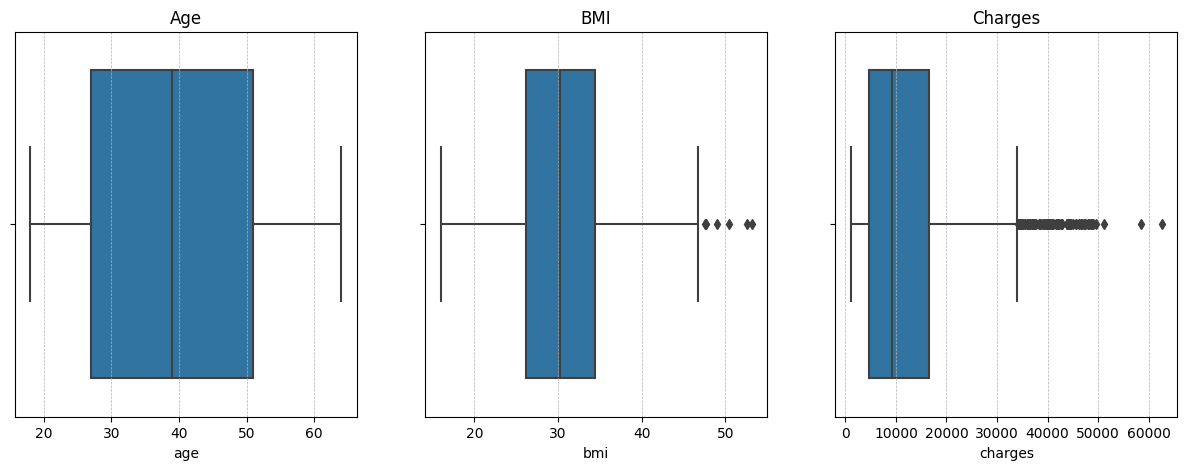

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax in axs:
    ax.set_facecolor('white')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Boxplot for the "age" column
sns.boxplot(x=X_train['age'], ax=axs[0])
axs[0].set_title('Age')

# Boxplot for the "bmi" column
sns.boxplot(x=X_train['bmi'], ax=axs[1])
axs[1].set_title('BMI')

# Boxplot for the "charges" column
sns.boxplot(x=X_train['charges'], ax=axs[2])
axs[2].set_title('Charges')

plt.show()

As the numbers already suggested, we observe potential outliers in the features "bmi" and "charges". The outliers in "bmi" are relatively limited, whereas in the boxplot of "charges", we can see several potential outliers. Whether we categorize all these points as outliers will be determined later.

In the following pairplot generated by seaborn for the features "age", "bmi" and "charges", we see:

**Scatterplots:**  
Each combination of features will be displayed as a scatterplot, showing the relationship between pairs of variables. For example, we see scatterplots of "age" vs. "bmi", "age" vs. "charges" and "bmi" vs. "charges". These plots provide insights into the correlation between pairs of variables. Positive correlations will be indicated by points sloping upwards from left to right, while negative correlations will slope downwards.  
**Diagonal Plots:**  
Along the diagonal, we see histograms for each individual feature. These histograms display the distribution of values for each variable. Like the almost symmetrical distribution of "bmi" and the right-skewed distribution of "charges".

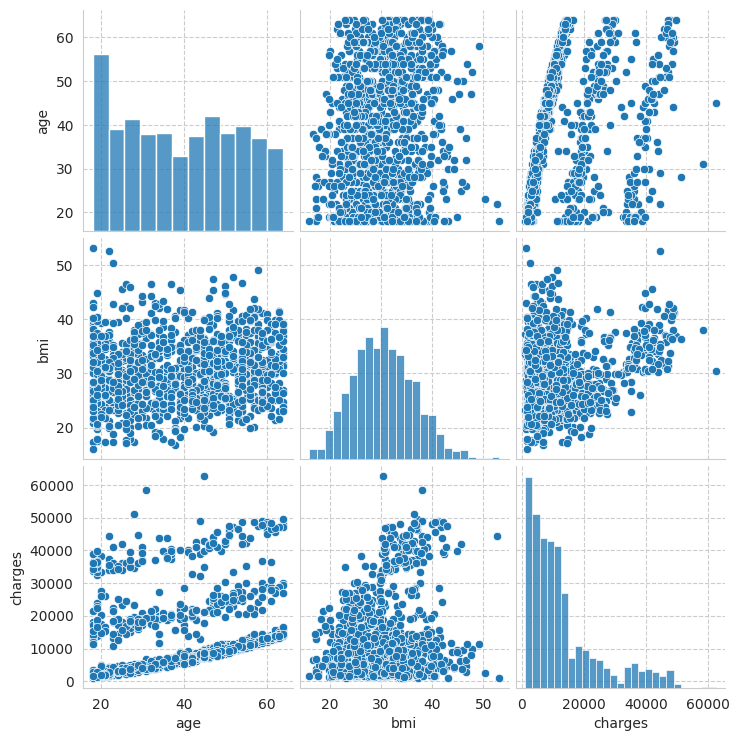

In [11]:
# Set the style to white and configure the grid
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.pairplot(X_train[['age', 'bmi', 'charges']])

plt.show()

A **heatmap** is a graphical representation of data where individual values are represented as colors. When used to show correlation matrices, it helps us visually understand the relationships between different variables in our dataset.  
  
**Color intensity** represents the strength of correlation:  
Blue represents negative correlations.  
Red represents positive correlations.  
Neutral colors (like white or light grey) indicate weak or no correlation.  
  
The **numbers within the heatmap** represent the Pearson correlation coefficient (often ranging between -1 and +1):  
+1: A perfect positive correlation. As one variable increases, the other also increases.  
-1: A perfect negative correlation. As one variable increases, the other decreases.  
0: No correlation. The variables don’t affect each other.  
The closer a value is to +1 or -1, the stronger the relationship.  

<Axes: >

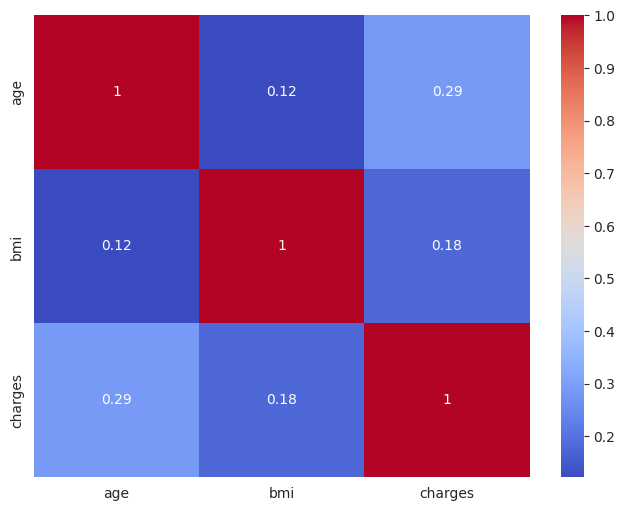

In [12]:
correlation_matrix = X_train[["age", "bmi", "charges"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

We can see a weak positive correlation between age an charges of 0.29 indicating that the older a person gets the higher the cahrges. 

## Interquartile Range Method (IQR)  
  
The IQR method stands as a reliable statistical tool for pinpointing outliers within a dataset. It hinges on quartiles, effectively segmenting the data into four equal parts. Specifically, the IQR is derived from the disparity between the third quartile (Q3) and the first quartile (Q1).  
In this methodology, Q1 and Q3 are initially computed to delineate the thresholds below which 25% and 75% of the data resides, respectively. Subsequently, the IQR is determined by subtracting Q1 from Q3, thereby capturing the spread of the middle 50% of the dataset. Potential outliers are flagged by data points falling below Q1 - 1.5 * IQR or exceeding Q3 + 1.5 * IQR. These values indicate observations that lie significantly outside the typical range of the dataset.  
  
Note:  
In the following plots the potential outliers are highlighted in red.

Number of outliers in age before removal: 0
Number of outliers in bmi before removal: 18
Number of outliers in charges before removal: 37


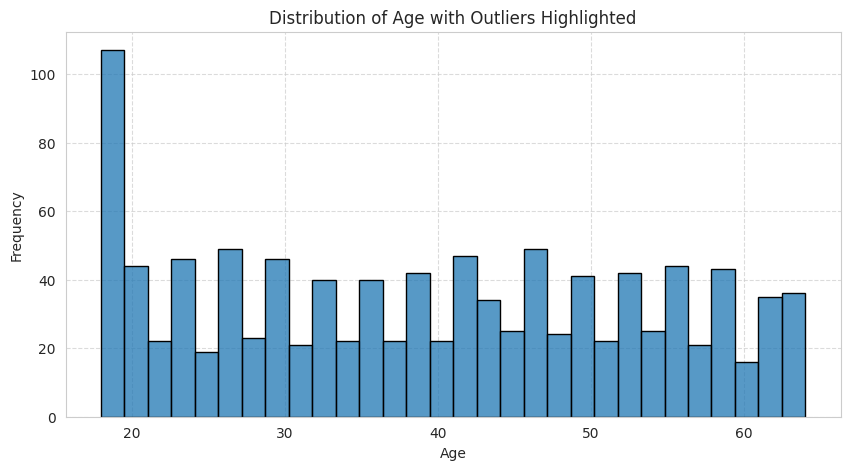

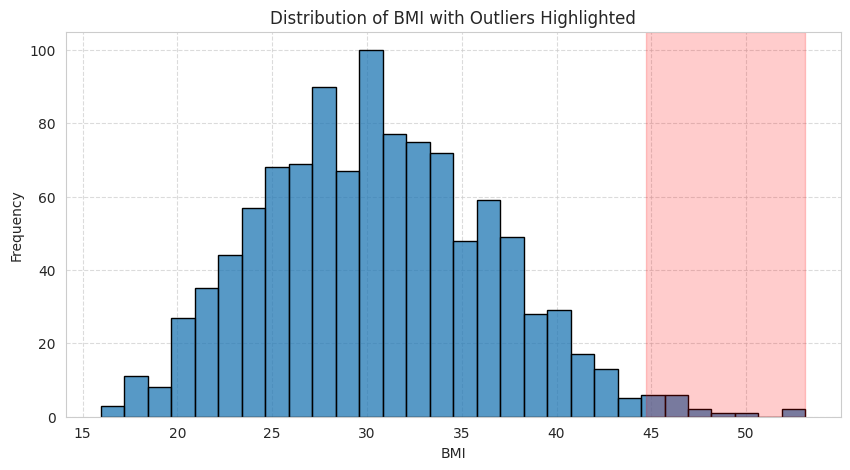

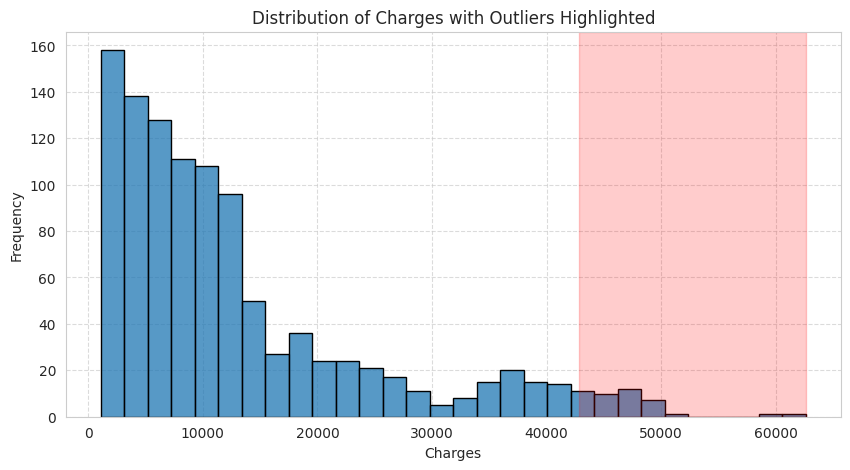

In [13]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, feature, lower_multiplier=1.5, upper_multiplier=1.5):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Calculate the lower bound for outliers
    lower_bound = Q1 - lower_multiplier * IQR
    # Calculate the upper bound for outliers
    upper_bound = Q3 + upper_multiplier * IQR
    outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    print("Number of outliers in", feature, "before removal:", outliers.sum())
    return outliers

# Find outliers for each feature separately
outliers_age_iqr = detect_outliers_iqr(X_train, 'age', lower_multiplier=1.5, upper_multiplier=1.5)
outliers_bmi_iqr = detect_outliers_iqr(X_train, 'bmi', lower_multiplier=1.5, upper_multiplier=1.2)
outliers_charges_iqr = detect_outliers_iqr(X_train, 'charges', lower_multiplier=1.5, upper_multiplier=2.25)

def plot_with_outliers(data, outliers, xlabel, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(data, bins=30, kde=False, edgecolor='k')
    plt.axvspan(data[outliers].min(), data[outliers].max(), color='red', alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_with_outliers(X_train['age'], outliers_age_iqr, 'Age', 'Distribution of Age with Outliers Highlighted')
plot_with_outliers(X_train['bmi'], outliers_bmi_iqr, 'BMI', 'Distribution of BMI with Outliers Highlighted')
plot_with_outliers(X_train['charges'], outliers_charges_iqr, 'Charges', 'Distribution of Charges with Outliers Highlighted')

In [14]:
# Combine outlier indices
all_outliers_indices_iqr = outliers_age_iqr | outliers_bmi_iqr | outliers_charges_iqr

# Define df_iqr using only the rows that are not outliers
df_iqr = X_train[~all_outliers_indices_iqr]

# Print information about the original and cleaned DataFrames
print("Shape of original X_train:", X_train.shape)
print("Shape of new df after removing outliers:", df_iqr.shape)
print("Number of removed outliers:", all_outliers_indices_iqr.sum())

Shape of original X_train: (1069, 12)
Shape of new df after removing outliers: (1015, 12)
Number of removed outliers: 54


With the IQR Method we removed 54 outliers from our dataset. We identified 18 outliers in the "bmi" feature and 37 outliers in the "charges" feature, totaling 55 outliers. However, it's possible that some indices appear more than once.

## Standard Deviation Method (STD)


The Standard Deviation Method utilizes the standard deviation to measure how data points are spread out around the mean of the dataset. We begin by computing the mean and standard deviation of the dataset. After calculating these values, we set a threshold for identifying outliers, it's often chosen to be 2 or 3 standard deviations from the mean. For instance, with a threshold of 3 standard deviations, any data point situated more than 3 standard deviations away from the mean is marked as a potential outlier. We identify these outliers by finding data points that are either below the mean minus the threshold times the standard deviation or above the mean plus the threshold times the standard deviation. These identified points are then considered outliers.

Since we removed many outliers from the df dataframe using the IQR method, we aim to reduce the number with the STD method. This will affect the results later on, given the dataset's small size. Therefore we stick to the standard value of 3 for the standard deviations.

Number of outliers in age before removal: 0
Number of outliers in bmi before removal: 4
Number of outliers in charges before removal: 11


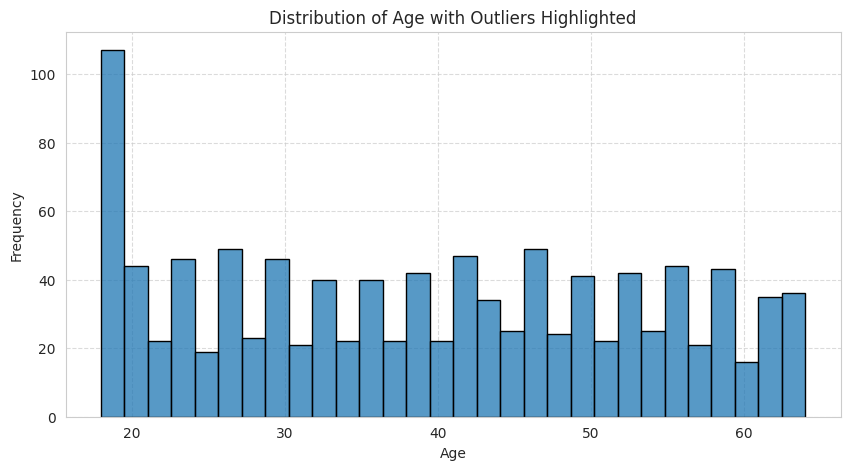

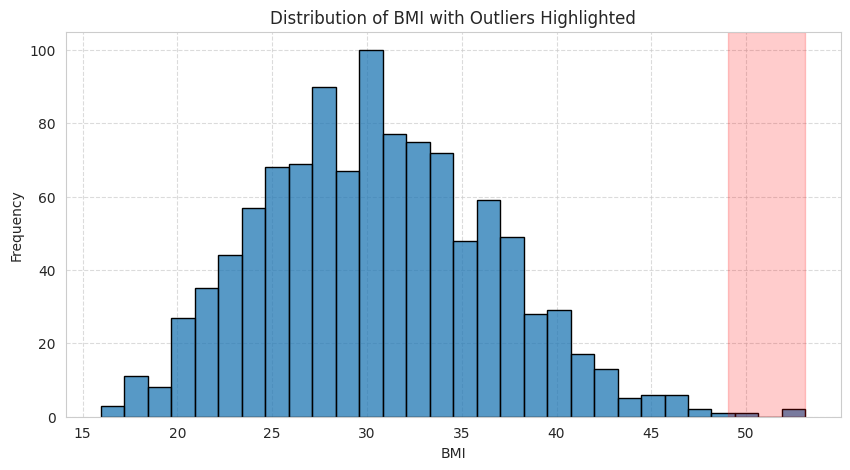

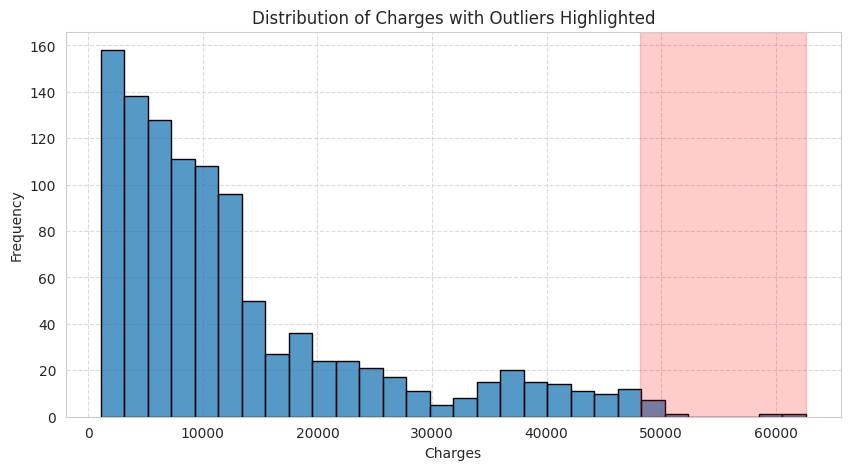

In [15]:
# Function to remove outliers using STD
def detect_outliers_std(df, feature, threshold=3):
    mean = df[feature].mean()
    std_dev = df[feature].std()
    outliers = (df[feature] - mean).abs() > threshold * std_dev
    print("Number of outliers in", feature, "before removal:", outliers.sum())
    return outliers

# Find outliers for each feature separately
outliers_age_std = detect_outliers_std(X_train, 'age', threshold=3)
outliers_bmi_std = detect_outliers_std(X_train, 'bmi', threshold=3)
outliers_charges_std = detect_outliers_std(X_train, 'charges', threshold=3)

def plot_with_outliers(data, outliers, xlabel, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(data, bins=30, kde=False, edgecolor='k')
    plt.axvspan(data[outliers].min(), data[outliers].max(), color='red', alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
plot_with_outliers(X_train['age'], outliers_age_std, 'Age', 'Distribution of Age with Outliers Highlighted')
plot_with_outliers(X_train['bmi'], outliers_bmi_std, 'BMI', 'Distribution of BMI with Outliers Highlighted')
plot_with_outliers(X_train['charges'], outliers_charges_std, 'Charges', 'Distribution of Charges with Outliers Highlighted')

Compared to the IQR method, the Standard Deviation (STD) method identifies outliers in the same regions of the data distribution.

In [16]:
# Combine outlier indices
all_outliers_indices_std = outliers_age_std | outliers_bmi_std | outliers_charges_std

# Define df_std using only the rows that are not outliers
df_std = X_train[~all_outliers_indices_std]

# Print information about the original and cleaned DataFrames
print("Shape of original X_train:", X_train.shape)
print("Shape of new df after removing outliers using STD method:", df_std.shape)
print("Number of removed outliers using STD method:", all_outliers_indices_std.sum())  

Shape of original X_train: (1069, 12)
Shape of new df after removing outliers using STD method: (1054, 12)
Number of removed outliers using STD method: 15


With the STD method we removed 15 outliers from our dataset.

## Density-Based Spatial Clustering of Applications with Noise

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is an unsupervised machine learning algorithm commonly used for clustering data. It operates by grouping together points that are closely packed together, marking these regions as clusters, while points that lie alone in low-density regions are considered noise or outliers. This method relies on two parameters: epsilon (ε), which defines the maximum distance between two points to be considered neighbors and the minimum number of points required to form a dense region. A point is classified as a core point if it has at least the minimum number of points within its epsilon radius; otherwise, it is classified as a border point or noise.  
  
We will apply DBSCAN in two different ways:

Version 1: We will directly apply DBSCAN to the three features "age", "bmi" and "charges" and then examine which data points are identified as outliers within by looking at the features pairwise.  
  
Version 2: By first applying DBSCAN pairwise to the features, we might be able to identify clusters that are well-defined in their respective dimensions. This allows for a finer detection of clusters that emerge within individual feature spaces. Subsequently, we apply DBSCAN to all three features simultaneously to fully account for the multidimensional structure of the data. This enables us to identify clusters that are consistent across all three dimensions and that might have been overlooked in the pairwise analyses.  
Combining both approaches might allows for a more comprehensive and robust cluster analysis, potentially yielding better results.

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### DBSCAN Version 1:
We apply DBSCAN to all three features simultaneously.

Number of clusters: 1
Distribution of clusters:
cluster
 0    1054
-1      15
Name: count, dtype: int64


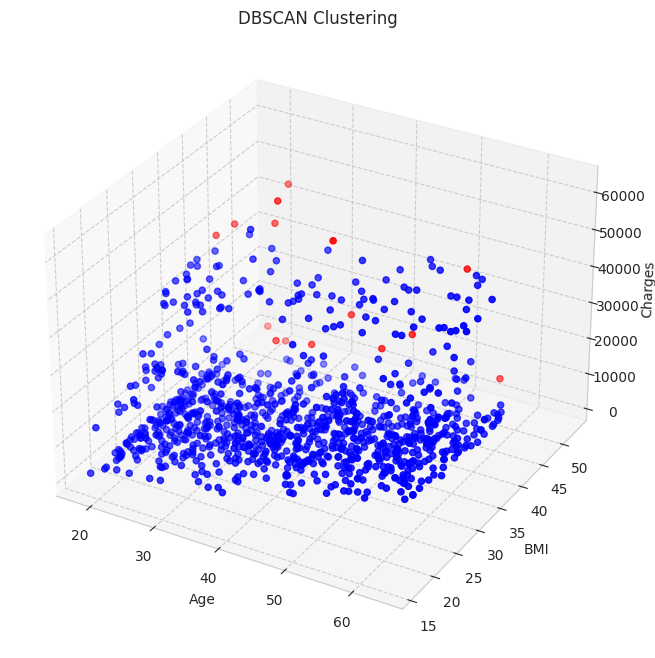

In [18]:
# Make a copy of the DataFrame
df_v1 = X_train.copy()

# Select the features
X = df_v1[['age', 'bmi', 'charges']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=15)
dbscan.fit(X_scaled)

# Add cluster labels to the DataFrame
df_v1['cluster'] = dbscan.labels_

# Display the number of clusters and their distribution
num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print("Number of clusters:", num_clusters)
print("Distribution of clusters:")
print(df_v1['cluster'].value_counts())

# Save the indices of outliers in index_0
index_0 = df_v1[df_v1['cluster'] == -1].index.tolist()

# Create a color list for the clusters
colors = ['blue' if label != -1 else 'red' for label in df_v1['cluster']]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the first three features with cluster colors
ax.scatter(df_v1['age'], df_v1['bmi'], df_v1['charges'], c=colors)
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
ax.set_title('DBSCAN Clustering')

plt.show()

By applying DBSCAN to all three features simultaneously, we identified 15 potential outliers (cluster -1). The outliers are colored red and all other data points are colored blue.   
  
We will examine the features pairwise to identify which data points are categorized as outliers.

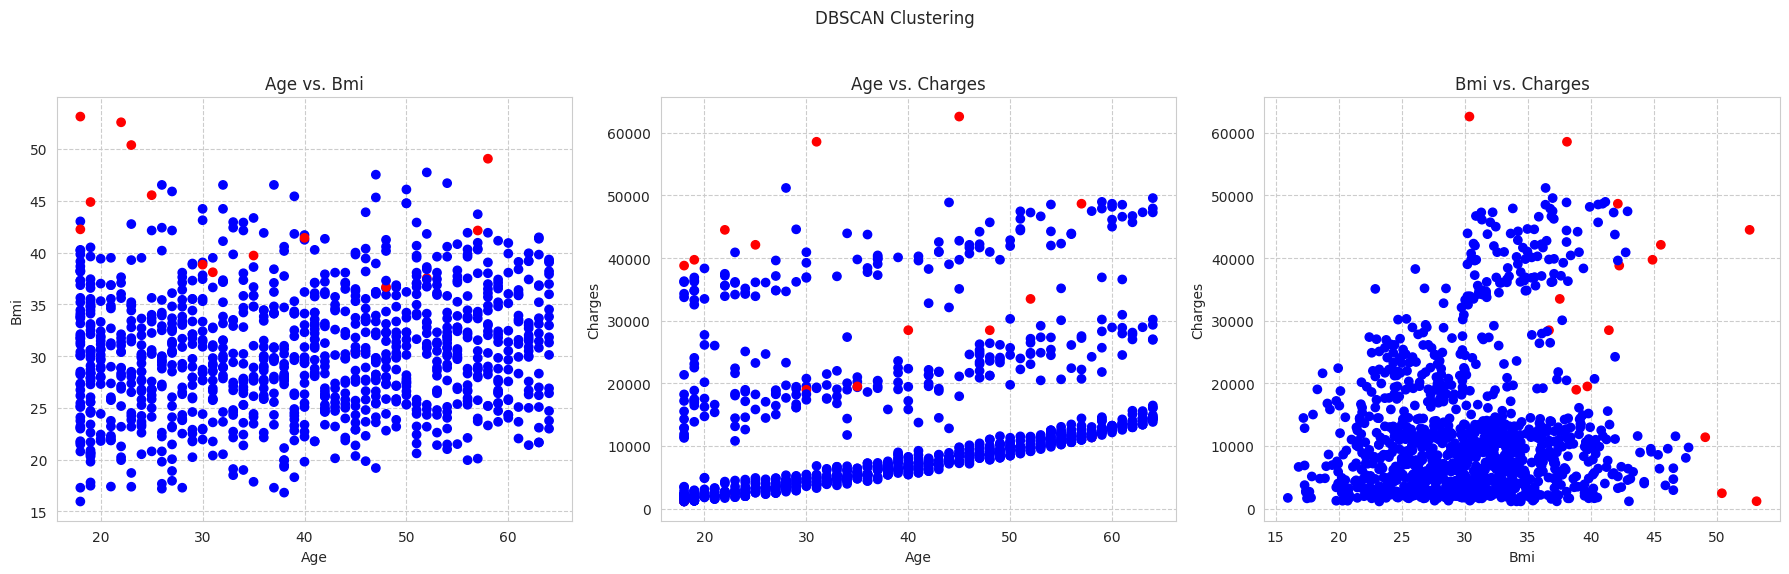

In [19]:
# 2D plots of pairs of the three features with cluster colors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define pairs of features for plotting
feature_pairs = [('age', 'bmi'), ('age', 'charges'), ('bmi', 'charges')]

# Iterate over axes and feature pairs
for ax, (feature1, feature2) in zip(axes, feature_pairs):
    ax.scatter(df_v1[feature1], df_v1[feature2], c=colors)
    ax.set_xlabel(feature1.capitalize())
    ax.set_ylabel(feature2.capitalize())
    ax.set_title(f'{feature1.capitalize()} vs. {feature2.capitalize()}')

plt.suptitle('DBSCAN Clustering')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

It is interesting to see which data points are now marked as outliers. When examining the features pairwise, some of these data points might not have been perceived as outliers at first glance. Some of the outliers are clustered closely to other data points. These points, which are still marked as outliers by DBSCAN, are only recognizable as outliers when we consider the multidimensional structure of the data.

In [20]:
# Remove outliers based on DBSCAN cluster labels
df_dbscan_v1 = df_v1.drop(index_0)

# Drop the 'cluster' column from the cleaned DataFrame
df_dbscan_v1.drop(columns=['cluster'], axis=1, inplace=True)

# Print information about the original and cleaned DataFrames
print("Shape of original X_train:", X_train.shape)
print("Shape of new df after removing outliers using DBSCAN method:", df_dbscan_v1.shape)

num_removed_outliers_v1 = len(index_0)
print("Number of removed outliers using DBSCAN method:", num_removed_outliers_v1)

Shape of original X_train: (1069, 12)
Shape of new df after removing outliers using DBSCAN method: (1054, 12)
Number of removed outliers using DBSCAN method: 15


With the DBSCAN (version 1) we removed 15 outliers from our dataset.

### DBSCAN Version 2:
We apply DBSCAN to the features pairwise. Then we apply DBSCAN to all features simultaneously.

Number of clusters: 1
Distribution of clusters:
cluster
 0    1060
-1       9
Name: count, dtype: int64


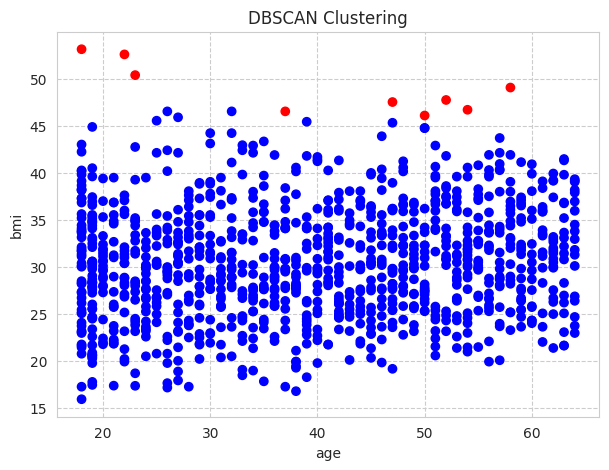

Number of clusters: 2
Distribution of clusters:
cluster
 0    958
 1    107
-1      4
Name: count, dtype: int64


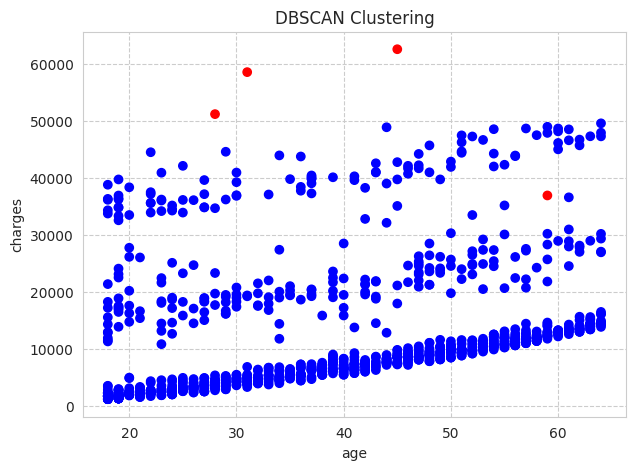

Number of clusters: 1
Distribution of clusters:
cluster
 0    1060
-1       9
Name: count, dtype: int64


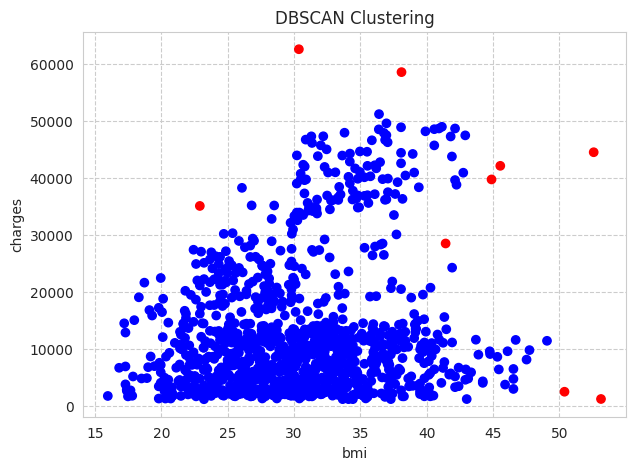

In [21]:
# Function for DBSCAN clustering
def dbscan_clustering(df, features, eps, min_samples):
    # Make a copy of the DataFrame
    df_v2 = df.copy()

    # Select the features
    X = df_v2[features]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X_scaled)

    # Add cluster labels to the DataFrame
    df_v2['cluster'] = dbscan.labels_

    # Display the number of clusters and their distribution
    num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    print("Number of clusters:", num_clusters)
    print("Distribution of clusters:")
    print(df_v2['cluster'].value_counts())

    # Save the indices of outliers
    outliers_index = df_v2[df_v2['cluster'] == -1].index.tolist()

    # Create a color list for the clusters
    colors = ['blue' if label != -1 else 'red' for label in df_v2['cluster']]

    # Create a scatter plot of the selected features with cluster colors
    plt.figure(figsize=(7, 5))
    plt.scatter(df_v2[features[0]], df_v2[features[1]], c=colors)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('DBSCAN Clustering')
    plt.show()

    return df_v2, outliers_index

df_v2_1, index_1 = dbscan_clustering(X_train, ['age', 'bmi'], eps=0.5, min_samples=10)
df_v2_2, index_2 = dbscan_clustering(X_train, ['age', 'charges'], eps=0.5, min_samples=12)
df_v2_3, index_3 = dbscan_clustering(X_train, ['bmi', 'charges'], eps=0.5, min_samples=9)

We will now apply DBSCAN to the three features simultaneously, after removing the outliers identified in the previous step. The values for epsilon and the minimum number of points required to form a cluster remain the same as in version 1: eps = 0.8, min_samples = 15

Number of outliers identified in the previous step: 17
Number of clusters: 1
Distribution of clusters:
cluster
 0    1043
-1       9
Name: count, dtype: int64


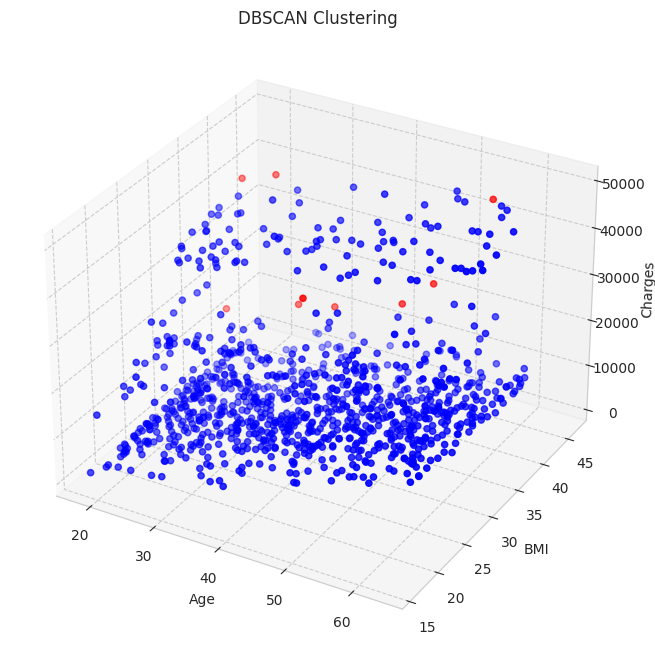

In [22]:
combined_indices = index_1 + index_2 + index_3
combined_indices = list(set(combined_indices))

# Create a DataFrame excluding the combined outliers
df_dbscan_v2_help = X_train.copy().drop(combined_indices)

# Select the features
X = df_dbscan_v2_help[['age', 'bmi', 'charges']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=7)
dbscan = DBSCAN(eps=0.8, min_samples=15)
dbscan.fit(X_scaled)

# Add cluster labels to the DataFrame
df_dbscan_v2_help['cluster'] = dbscan.labels_

# Number of outliers identified in the previous step
print("Number of outliers identified in the previous step:", len(combined_indices))

# Display the number of clusters and their distribution
num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print("Number of clusters:", num_clusters)
print("Distribution of clusters:")
print(df_dbscan_v2_help['cluster'].value_counts())

# Save the indices of outliers in index_4
index_4 = df_dbscan_v2_help[df_dbscan_v2_help['cluster'] == -1].index.tolist()

# Create a color list for the clusters
colors = ['blue' if label != -1 else 'red' for label in df_dbscan_v2_help['cluster']]

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the first three features with cluster colors
ax.scatter(df_dbscan_v2_help['age'], df_dbscan_v2_help['bmi'], df_dbscan_v2_help['charges'], c=colors)
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
ax.set_title('DBSCAN Clustering')

plt.show()

We removed 17 outliers from the data and then applied DBSCAN to the remaining data, identifying another 9 outliers (cluster -1).

In [23]:
# Remove outliers based on DBSCAN cluster labels
df_dbscan_v2 = df_dbscan_v2_help.drop(index_4)

# Drop the 'cluster' column from the cleaned DataFrame
df_dbscan_v2.drop(columns = ['cluster'], axis = 1, inplace = True)

# Print information about the original and cleaned DataFrames
print("Shape of original X_train:", X_train.shape)
print("Shape of new df after removing outliers using DBSCAN method:", df_dbscan_v2.shape)

num_removed_outliers_v2 = len(combined_indices)+len(index_4)
print("Number of removed outliers using DBSCAN method:", num_removed_outliers_v2)

Shape of original X_train: (1069, 12)
Shape of new df after removing outliers using DBSCAN method: (1043, 12)
Number of removed outliers using DBSCAN method: 26


Comparing both approaches, we removed 26 more data points using the second version.

# Scalers and Model

In the previous steps, we created 5 dataframes. The dataframe X_train, where no outliers were removed and the dataframes df_iqr, df_std, df_dbscan_v1 and df_dbscan_v2, where we removed outliers from the X_train dataframe using different approaches. Now, we aim to use linear regression as the algorithm and "charges" as the target variable. We will apply three different scaling methods to the dataframes and compare the results.  
  
We won't optimize the linear regression model but rather focus on comparing the effects of outliers and scalers.

**Linear Regression** is a simple yet powerful statistical technique used for modeling the relationship between a dependent variable and one or more independent variables. In essence, it aims to find the best-fitting linear equation that describes the relationship between the input variables and the output variable.

When dealing with outliers in the data, Linear Regression can be sensitive to extreme values, especially if they exert a disproportionate influence on the model's parameters. Outliers can distort the estimated coefficients, affecting the overall performance of the model. Therefore, it's essential to preprocess the data appropriately to mitigate the impact of outliers.  
One common preprocessing step is the use of scalers. Scalers are transformation techniques applied to the features of the dataset to ensure that they are on a similar scale. This scaling process helps improve the convergence properties of optimization algorithms and prevents certain features from dominating others. 
Since we'll be using the "charges" feature as the target variable and the "age" and "bmi" features exhibit similar distributions (even before removing outliers), we might not observe significant differences in the results after applying different scalers. However, it's still valuable to compare the outcomes when using the scalers after we removed outliers.

**We will compre the following three scalers:**  
**StandardScaler:** When using StandardScaler with LinearRegression, scaling features can be crucial as LinearRegression assumes that the features are on the same scale. StandardScaler standardizes features by removing the mean and scaling to unit variance, which can help the model converge faster and improve its performance.  
**MinMaxScaler:** MinMaxScaler scales features to a specified range, typically between zero and one. While LinearRegression is not as sensitive to feature scaling as some other algorithms, MinMaxScaler can still be beneficial in cases where the features have varying magnitudes or when interpretability of coefficients is important.  
**RobustScaler:** RobustScaler is particularly useful for LinearRegression when dealing with datasets containing outliers. It scales features using robust statistics, such as the median and interquartile range, making it less sensitive to outliers compared to StandardScaler. This can lead to more robust and reliable model performance.

To evalutae our model we use **Mean Squared Error (MSE) and R-squared (R2)**.  
  
MSE measures the average squared difference between the predicted values and the actual values. A lower MSE indicates that the model's predictions are closer to the actual values, implying better performance. It depends on the scale of the data.  
R2, on the other hand, represents the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates that the model does not explain any of the variability in the dependent variable beyond the mean. Higher R2 values indicate that the model explains a greater proportion of the variance in the target variable.  
  
In summary, while MSE quantifies the average error of the model's predictions, R2 provides a measure of how well the model fits the data relative to a simple mean-based model. Together, these metrics offer valuable insights into the performance and predictive power of a model.

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

The following code defines a loop where the 5 dataframes are scaled with the 3 scalers, transformed with PolynomialFeatures of degree 2 and then a LinearRegression model is trained. Finally, the results are generated and compared.

In [25]:
# Adding Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_test_poly = poly.fit_transform(X_test)

In [26]:
# Define scalers and their names in lists
scalers = [
    None,  # No scaler for the case without scaling
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler()
]
scaler_names = [
    "None",
    "StandardScaler",
    "MinMaxScaler",
    "RobustScaler"
]

# Dataframes
dfs = [X_train, df_iqr, df_std, df_dbscan_v1, df_dbscan_v2]
df_names = ["X_train", "df_iqr", "df_std", "df_dbscan_v1", "df_dbscan_v2"]

results_list = []

# Iterate over dataframes and scalers
for dataframe, df_name in zip(dfs, df_names):
    df_copy = dataframe.copy()
    X = df_copy.drop(['charges'], axis=1)
    y = df_copy['charges']
    
    X = poly.fit_transform(X)
    
    for scaler, scaler_name in zip(scalers, scaler_names):
        if scaler is not None:
            X_train_scaled = scaler.fit_transform(X)
            X_test_scaled = scaler.transform(X_test_poly.copy())
        else:
            X_train_scaled = X
            X_test_scaled = X_test_poly.copy()
        
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_scaled, y)
        
        # Predictions
        lin_reg_train_pred = lin_reg.predict(X_train_scaled)
        lin_reg_test_pred = lin_reg.predict(X_test_scaled)
        
        # Calculate metrics
        mse_train = mean_squared_error(y, lin_reg_train_pred)
        mse_test = mean_squared_error(y_test, lin_reg_test_pred)
        r2_train = r2_score(y, lin_reg_train_pred)
        r2_test = r2_score(y_test, lin_reg_test_pred)
        
        # Append results to the list
        results_list.append({'DataFrame': df_name,
                             'Scaler': scaler_name,
                             'MSE Train': mse_train,
                             'R2 Train': r2_train,
                             'MSE Test': mse_test,
                             'R2 Test': r2_test})

# Create DataFrame from results list
results = pd.DataFrame(results_list)

# Change formats
results['MSE Train'] = results['MSE Train'].apply(lambda x: '{:,.0f}'.format(x))
results['R2 Train'] = results['R2 Train'].apply(lambda x: '{:,.6f}'.format(x))
results['MSE Test'] = results['MSE Test'].apply(lambda x: '{:,.0f}'.format(x))
results['R2 Test'] = results['R2 Test'].apply(lambda x: '{:,.6f}'.format(x))

results

,DataFrame,Scaler,MSE Train,R2 Train,MSE Test,R2 Test
0,X_train,None,"22,724,228",0.834026,"21,585,844",0.882530
1,X_train,StandardScaler,"22,786,481",0.833572,"21,355,045",0.883786
2,X_train,MinMaxScaler,"22,729,158",0.833990,"21,596,964",0.882469
3,X_train,RobustScaler,"22,724,228",0.834026,"21,585,844",0.882530
4,df_iqr,None,"21,504,208",0.778913,"22,268,015",0.878818
5,df_iqr,StandardScaler,"21,589,228",0.778039,"22,397,337",0.878114
6,df_iqr,MinMaxScaler,"21,506,502",0.778890,"22,253,740",0.878895
7,df_iqr,RobustScaler,"21,507,626",0.778878,"22,246,123",0.878937
8,df_std,None,"21,463,905",0.824282,"21,621,242",0.882337
9,df_std,StandardScaler,"21,502,524",0.823966,"21,764,394",0.881558


Let's examine the results when none of the scalers are used:

In [27]:
# Creating a DataFrame with rows where Scaler is None
none_scaler_df = results[results['Scaler'] == 'None'].copy()  # Kopie erstellen

# Resetting the index
none_scaler_df.reset_index(drop=True, inplace=True)

# Calculate the sum of all outliers for IQR and standard deviation methods
sum_outliers_iqr = all_outliers_indices_iqr.sum()
sum_outliers_std = all_outliers_indices_std.sum()

number_of_removed_outliers = [0, sum_outliers_iqr, sum_outliers_std, num_removed_outliers_v1, num_removed_outliers_v2]

# Add new column
none_scaler_df['Number of removed Outliers'] = number_of_removed_outliers

print("DataFrame with Scaler = None:")
none_scaler_df

DataFrame with Scaler = None:


,DataFrame,Scaler,MSE Train,R2 Train,MSE Test,R2 Test,Number of removed Outliers
0,X_train,None,"22,724,228",0.834026,"21,585,844",0.882530,0
1,df_iqr,None,"21,504,208",0.778913,"22,268,015",0.878818,54
2,df_std,None,"21,463,905",0.824282,"21,621,242",0.882337,15
3,df_dbscan_v1,None,"20,212,366",0.843406,"21,785,828",0.881442,15
4,df_dbscan_v2,None,"19,183,395",0.848363,"21,953,264",0.880530,26


### Final Thoughts

**Base Model (No Outlier Removal):**  
The baseline (X_train without outlier removal) shows decent performance with an MSE of 21.59M on the test set and an R² of 0.883.  
This gives us a reference point to compare how different outlier removal techniques impact the model's performance.  
  
**IQR-Based Outlier Removal:**  
The IQR method removes 54 outliers, the most aggressive approach here.  
The model sees a slight decline in test set performance (MSE increases to 22.27M, R² drops slightly to 0.879). This suggests that the aggressive removal of outliers might have led to underfitting, as the model now captures less variability in the test set.  

**STD-Based Outlier Removal (Removing Outliers ±3 Standard Deviations):**  
Here, 15 outliers are removed, with a minimal difference in train and test set performance compared to the baseline.  
Removing outliers using the standard deviation appears to have a mild effect but doesn’t hurt generalization. It’s important to note that while some overfitting could occur (since train MSE is low), the impact is minor, suggesting this method is neither too conservative nor too aggressive.  
  
**DBSCAN-Based Outlier Removal (v1 and v2):**  
DBSCAN v1 (15 outliers removed):  
Removing 15 outliers using DBSCAN v1 achieves better training performance (lower MSE on train) than the baseline and STD method. However, the test performance is slightly worse than the baseline, indicating some degree of overfitting. DBSCAN v1 may be detecting more significant but less impactful outliers.  
  
DBSCAN v2 (26 Outliers Removed):  
DBSCAN v2 performs well but removes more outliers than necessary, which might lean toward a small degree of overfitting. While the model generalizes well, the fact that the gap between train and test MSE is larger than in v1 or the baseline suggests that it's important not to over-remove outliers.  
  
**Evaluation of STD vs. DBSCAN v1 (15 Outliers Removed):**  
Both techniques remove an equal number of outliers (15), but their performance differs slightly:  
STD Removal:  
Train R²: 0.824 | Test R²: 0.882  
The training performance is lower than DBSCAN v1 (indicating more regularization), but the test performance is slightly better.  
DBSCAN v1:  
Train R²: 0.843 | Test R²: 0.881  
DBSCAN v1 performs better on the training set but does slightly worse on the test set than the STD method. 
This indicates that DBSCAN v1 might be focusing on outliers that affect training performance more strongly, while the STD method removes outliers that are less impactful but keeps the model more generalizable. Although DBSCAN v1 provides a better fit on the training data, its test performance doesn’t surpass the STD method, suggesting a small risk of overfitting.  
  
**Most Aggressive Technique: IQR (54 Outliers Removed):**  
IQR removes the largest number of outliers and while it reduces the training error, it causes a larger performance drop on the test set.  
Given that the IQR method removes so many data points (54), the model is likely overfitting, meaning it’s oversimplified and fails to capture the complexities of the unseen data. This suggests that removing too many outliers aggressively can lead to a loss of valuable information and hurt the model's generalization ability.  
  
**STD method and DBSCAN v1**, which both remove 15 outliers, achieve more balanced results. STD seems to be a bit more conservative, which can be beneficial for generalization, while DBSCAN v1 is slightly better for training but has a higher risk of overfitting.
The trade-off between training and test performance with these techniques suggests that a moderate approach (removing 10-20 outliers) strikes a good balance.  
  
**Conclusion:**
The most promising approach semms to be the STD-based outlier removal (removing 15 outliers). It strikes the best balance between removing harmful outliers and retaining generalization ability. It keeps the model performance close to the baseline and avoids large gaps between training and test scores.  
DBSCAN v1 also performs reasonably well, though it introduces a bit more overfitting. It could be a good option when we want to focus more on training performance without sacrificing too much test accuracy.  
The IQR method, though removing the most outliers, shows that aggressive outlier removal can lead to worse generalization, highlighting the need for more selective techniques.  
  
**Choice of Scaler:**  
Across most datasets (X_train, df_std, df_dbscan_v1, df_dbscan_v2), the StandardScaler did not significantly outperform other scalers, but it offered consistent results, with similar test MSE and R² compared to the unscaled data.  
Since StandardScaler performs consistently well without significant performance degradation, it’s a safe choice if the feature scales vary widely.

**Note:**  
Since the linear regression model we used has **no hyperparameter optimization**, it’s important to keep in mind that these results are preliminary and could be further improved with tuning. In other words, while the performance metrics (MSE and R²) we observed provide valuable insights, they don't represent the best possible outcome because the model's full potential hasn’t been unlocked yet.  
  
MSE and R² may change significantly with hyperparameter tuning. For example, if we observed that the test set performance declines after removing too many outliers (as in the IQR case), hyperparameter tuning could help balance the model complexity and data variability more effectively, yielding better generalization.
  
Despite the absence of hyperparameter tuning, the results we’ve obtained still provide useful comparisons between outlier removal techniques and scalers.  
Without optimization, it’s normal for the model to show some signs of overfitting or underfitting depending on the data cleaning methods used. This is because the model hasn’t been adjusted to manage the complexity of the training data fully.